In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn
from torchsummary import summary

import matplotlib.pyplot as plt

## Torch Imports

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
batch_size, hidden_size = 128, 64
input_size, seq_len = 28, 28
num_classes = 10
num_channels = 1

In [4]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.CenterCrop(size=(input_size, seq_len)),
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ]
    )
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.CenterCrop(size=(input_size, seq_len)),
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ]
    )
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11740113.17it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 205338.15it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3911440.49it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18236720.43it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

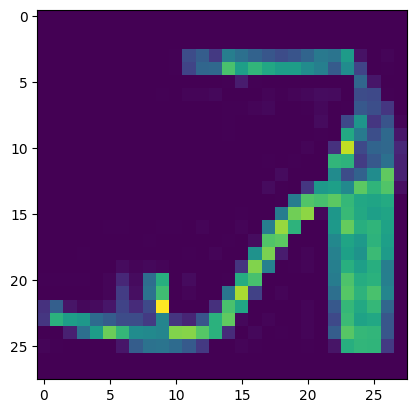

In [46]:
for (x, y) in train_dataloader:
    plt.imshow(x[0].squeeze())
    break

## Torch RNN

In [60]:
def train_model(data, model, loss_fn, optimizer, epochs: int = 3):
    count = 0
    n_total_steps = len(data)

    for epoch in range(epochs):
        for step, (images, labels) in enumerate(data):
            optimizer.zero_grad()

            train  = images.view(size=(-1, seq_len, input_size)).to(device)
            labels = labels.to(device)

            output = model(train)

            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

            count += 1

            if (step+1) % 50 == 0:
                print (f'Epoch [{epoch+1}/{epochs}], Step [{step+1}/{n_total_steps}], Loss: {loss.item():.4f}')
        print('\n')

In [61]:
def accuracy(data, model):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in data:
            images = images.view(size=(-1, seq_len, input_size)).to(device)
            labels = labels.to(device)

            output = model(images)

            _, predicted = torch.max(output.data, dim=1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = n_correct / n_samples
        return acc

### CustomRNN: LinearEx (Dense), RNNCellEx (memory_cell), RNNLayer (simpleRNN)

In [62]:
class LinearEx(nn.Module):
    __constants__ = ['in_features', 'out_features', 'bias', 'device']

    def __init__(self, in_features: int, out_features: int, bias: bool = True, device: str = 'cpu', **kwargs):
        super(LinearEx, self).__init__(**kwargs)

        self.use_bias = bias

        self.weights = nn.Parameter(data=torch.randn(size=(out_features, in_features), device=device), requires_grad=True)
        if self.use_bias: self.bias = nn.Parameter(data=torch.randn(size=(out_features, 1), device=device), requires_grad=True)

    def forward(self, inputs: torch.Tensor):
        inputs = inputs.to(device)

        if self.use_bias:
            return torch.matmul(inputs, torch.transpose(self.weights, dim0=0, dim1=1)) + self.bias.squeeze()
        else: return torch.matmul(inputs, torch.transpose(self.weights, dim0=0, dim1=1))

torch.Size([128, 1, 28, 64])


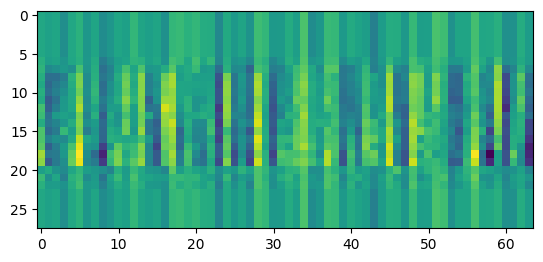

In [63]:
linear_layer = LinearEx(in_features=input_size, out_features=hidden_size, device=device)
layer_pred = linear_layer(next(iter(train_dataloader))[0])
print(layer_pred.size())
plt.imshow(layer_pred.detach().cpu()[0].squeeze())

In [64]:
class RNNCellEx(nn.Module):
    __constants__ = ['input_size', 'hidden_size', 'bias', 'nonlinearity', 'device']

    def __init__(self, input_size: int, hidden_size: int, bias: bool = True, nonlinearity: str = 'tanh', device: str = 'cpu', **kwargs):
        super(RNNCellEx, self).__init__(**kwargs)

        self.nonlinearity = nonlinearity

        self.in_to_hidden = LinearEx(in_features=input_size, out_features=hidden_size, bias=False, device=device)
        self.hidden_to_hidden = LinearEx(in_features=hidden_size, out_features=hidden_size, bias=bias, device=device)

        self.layer_norm = nn.LayerNorm(normalized_shape=hidden_size).to(device)

    def forward(self, inputs: torch.Tensor, states: torch.Tensor) -> torch.Tensor:
        if self.nonlinearity == 'tanh':
            tanh = nn.Tanh()
            states = tanh(self.layer_norm(self.in_to_hidden(inputs) + self.hidden_to_hidden(states)))
            return states

        elif self.nonlinearity == 'relu':
            relu = nn.ReLU()
            states = relu(self.layer_norm(self.in_to_hidden(inputs) + self.hidden_to_hidden(states)))
            return states

        else:
            raise RuntimeError('Unknown nonlinearity: %s' % self.nonlinearity)

In [65]:
imgs, _ = next(iter(train_dataloader))

In [66]:
input = imgs.squeeze() #(batch_size, seq_len, input_size): batch_size - time steps in the one sequence - num_sequences
h0 = torch.zeros(1, seq_len, hidden_size) # time steps in the one sequence - num_sequences
rnn_cell_layer = RNNCellEx(input_size=input_size, hidden_size=hidden_size, device=device)
pred = rnn_cell_layer(input, h0)
pred.shape

torch.Size([128, 28, 64])

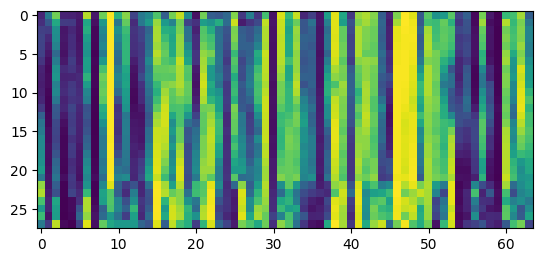

In [67]:
plt.imshow(pred[0].detach().cpu())

In [68]:
class RNNLayer(nn.Module):
    __constants__ = ['input_size', 'hidden_size', 'output_size', 'stacking', 'bias', 'nonlinearity', 'device']

    def __init__(self, input_size: int, hidden_size: int, output_size: int, stacking: bool = False, bias: bool = True,
                 nonlinearity: str = 'tanh', device: str = 'cpu', **kwargs):
        super(RNNLayer, self).__init__(**kwargs)

        self.stacking = stacking
        self.hidden_size = hidden_size

        cond_factory = {'nonlinearity': nonlinearity, 'bias': bias, 'device': device}

        self.rnn_input_cell = RNNCellEx(input_size=input_size, hidden_size=hidden_size, **cond_factory)
        if self.stacking: self.rnn_hidden_cell = RNNCellEx(input_size=hidden_size, hidden_size=hidden_size, **cond_factory)

        self.hidden_to_output = LinearEx(in_features=hidden_size, out_features=output_size, bias=bias, device=device)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        states = torch.zeros(size=(2 if self.stacking else 1, inputs.size(1), self.hidden_size)).to(device)

        self.memory_cell = self.rnn_input_cell(inputs, states[0])
        if self.stacking: self.memory_cell = self.rnn_hidden_cell(self.memory_cell, states[1])

        outputs = self.hidden_to_output(self.memory_cell[:, -1, :])
        return outputs

In [69]:
model_custom = RNNLayer(input_size=input_size, hidden_size=hidden_size, output_size=num_classes, stacking=True, nonlinearity='relu').to(device)
model_custom

RNNLayer(
  (rnn_input_cell): RNNCellEx(
    (in_to_hidden): LinearEx()
    (hidden_to_hidden): LinearEx()
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (rnn_hidden_cell): RNNCellEx(
    (in_to_hidden): LinearEx()
    (hidden_to_hidden): LinearEx()
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (hidden_to_output): LinearEx()
)

In [70]:
summary(model_custom, input_size=input.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          LinearEx-1               [-1, 28, 64]               0
          LinearEx-2                   [-1, 64]              64
         LayerNorm-3               [-1, 28, 64]             128
         RNNCellEx-4               [-1, 28, 64]               0
          LinearEx-5               [-1, 28, 64]               0
          LinearEx-6                   [-1, 64]              64
         LayerNorm-7               [-1, 28, 64]             128
         RNNCellEx-8               [-1, 28, 64]               0
          LinearEx-9                   [-1, 10]              10
Total params: 394
Trainable params: 256
Non-trainable params: 138
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.00
Estimated Total Size (MB): 0.09
-------------------------------------------------

In [71]:
train_model(
    data=train_dataloader,
    model=model_custom,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model_custom.parameters(), lr=1e-2),
    epochs=3
)

Epoch [1/3], Step [50/469], Loss: 1.4891
Epoch [1/3], Step [100/469], Loss: 1.4580
Epoch [1/3], Step [150/469], Loss: 1.3908
Epoch [1/3], Step [200/469], Loss: 1.3963
Epoch [1/3], Step [250/469], Loss: 1.3965
Epoch [1/3], Step [300/469], Loss: 1.3071
Epoch [1/3], Step [350/469], Loss: 1.1780
Epoch [1/3], Step [400/469], Loss: 1.3890
Epoch [1/3], Step [450/469], Loss: 1.4222


Epoch [2/3], Step [50/469], Loss: 1.3067
Epoch [2/3], Step [100/469], Loss: 1.2539
Epoch [2/3], Step [150/469], Loss: 1.4023
Epoch [2/3], Step [200/469], Loss: 1.2895
Epoch [2/3], Step [250/469], Loss: 1.2619
Epoch [2/3], Step [300/469], Loss: 1.2062
Epoch [2/3], Step [350/469], Loss: 1.3313
Epoch [2/3], Step [400/469], Loss: 1.3228
Epoch [2/3], Step [450/469], Loss: 1.3324


Epoch [3/3], Step [50/469], Loss: 1.3044
Epoch [3/3], Step [100/469], Loss: 1.3330
Epoch [3/3], Step [150/469], Loss: 1.2596
Epoch [3/3], Step [200/469], Loss: 1.1850
Epoch [3/3], Step [250/469], Loss: 1.3055
Epoch [3/3], Step [300/469], Loss

In [72]:
print('accuracy on train: %s' % accuracy(train_dataloader, model_custom))
print('accuracy on test: %s' % accuracy(test_dataloader, model_custom))

accuracy on train: 0.47008333333333335
accuracy on test: 0.4707


### Torch RNN

In [73]:
class RNNTorch(nn.Module):
    __constants__ = ['input_size', 'hidden_size', 'output_size', 'num_layers', 'bias', 'nonlinearity', 'device']

    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int = 1, bias: bool = True,
                 nonlinearity: str = 'tanh', device: str = 'cpu', **kwargs):
        super(RNNTorch, self).__init__(**kwargs)

        cond_factory = {'nonlinearity': nonlinearity, 'bias': bias, 'device': device}

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, **cond_factory)

        self.hidden_to_output = LinearEx(in_features=hidden_size, out_features=output_size, bias=bias, device=device)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        inputs = inputs.to(device)

        self.memory_cell, states = self.rnn(inputs)

        outputs = self.hidden_to_output(self.memory_cell[:, -1, :])
        return outputs

In [74]:
model_torch = RNNTorch(input_size=input_size, hidden_size=hidden_size, output_size=num_classes, num_layers=2, nonlinearity='relu', device=device)
model_torch

RNNTorch(
  (rnn): RNN(28, 64, num_layers=2)
  (hidden_to_output): LinearEx()
)

In [75]:
summary(model_torch, input_size=input.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 28, 64], [-1, 28, 64]]               0
          LinearEx-2                   [-1, 10]              10
Total params: 10
Trainable params: 0
Non-trainable params: 10
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 24.50
Params size (MB): 0.00
Estimated Total Size (MB): 24.50
----------------------------------------------------------------


In [76]:
train_model(
    data=train_dataloader,
    model=model_torch,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model_torch.parameters(), lr=1e-2),
    epochs=3
)

Epoch [1/3], Step [50/469], Loss: 1.6187
Epoch [1/3], Step [100/469], Loss: 1.4603
Epoch [1/3], Step [150/469], Loss: 1.3195
Epoch [1/3], Step [200/469], Loss: 1.2791
Epoch [1/3], Step [250/469], Loss: 1.3975
Epoch [1/3], Step [300/469], Loss: 1.5253
Epoch [1/3], Step [350/469], Loss: 1.3180
Epoch [1/3], Step [400/469], Loss: 1.2681
Epoch [1/3], Step [450/469], Loss: 1.3411


Epoch [2/3], Step [50/469], Loss: 1.3535
Epoch [2/3], Step [100/469], Loss: 1.4217
Epoch [2/3], Step [150/469], Loss: 1.4486
Epoch [2/3], Step [200/469], Loss: 1.3739
Epoch [2/3], Step [250/469], Loss: 1.3606
Epoch [2/3], Step [300/469], Loss: 1.3600
Epoch [2/3], Step [350/469], Loss: 1.1881
Epoch [2/3], Step [400/469], Loss: 1.2913
Epoch [2/3], Step [450/469], Loss: 1.3853


Epoch [3/3], Step [50/469], Loss: 1.3525
Epoch [3/3], Step [100/469], Loss: 1.4933
Epoch [3/3], Step [150/469], Loss: 1.2161
Epoch [3/3], Step [200/469], Loss: 1.3433
Epoch [3/3], Step [250/469], Loss: 1.3296
Epoch [3/3], Step [300/469], Loss

In [77]:
print('accuracy on train: %s' % accuracy(train_dataloader, model_torch))
print('accuracy on test: %s' % accuracy(test_dataloader, model_torch))

accuracy on train: 0.4655666666666667
accuracy on test: 0.4634
